In [2]:
from ia_model.data_preparation import load_data, prepare_data, split_data
# from ia_model.model import  train_model, evaluate_model, save_model, build_dynamic_model
from ia_model.utils import ia_plot_history
from ia_model.model_final import grid_evaluate_combinations,objective, build_best_model
import joblib
import optuna
from tqdm.auto import tqdm

2024-05-03 20:51:41.580372: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-03 20:51:41.582837: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-03 20:51:41.614188: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 20:51:41.614207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 20:51:41.615097: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [4]:
# Configuration parameters for the model and data preparation
FILE_PATH = 'aggregated_data4.csv' #This data can be download from https://rcavieses.pythonanywhere.com/
FEATURE_COL = ['NOMBRE PRINCIPAL','NOMBRE ESTADO','NOMBRE OFICINA','SST','PESO DESEMBARCADO_KILOGRAMOS']#Change this if you want to add input variables
TARGET_COL = 'PESO DESEMBARCADO_KILOGRAMOS'
CATEGORICAL_COL = ['NOMBRE PRINCIPAL','NOMBRE ESTADO','NOMBRE OFICINA']
NUMERIC_COL = ['PESO DESEMBARCADO_KILOGRAMOS','SST']
steps_forecast = 12
time_steps= 12 # number of steps that lstm forecast, change this will be errors on scoore metrics ;
# Example 
neurons_list = [264]
layers_list = [6]
activations_list = ['linear']  # List of activation functions to test, possible choice ['relu', 'sigmoid','tanh'] 
EPOCHS = 150
BATCH_SIZE = 24
MODEL_PATH = 'mi_modelo.h5'
SCALER_X_PATH = 'scaler_X.pkl'
SCALER_Y_PATH = 'scaler_Y.pkl'




In [5]:
# Load and prepare data
df = load_data(str(FILE_PATH))
X, y, scaler_x,scaler_y, encoder , n_features = prepare_data(df, TARGET_COL, time_steps,CATEGORICAL_COL,NUMERIC_COL)
X_train, X_test, y_train, y_test = split_data(X, y)

### grid search method

In [ ]:
# Build model and test different combination to find the best combination
best_configuration, best_mse, best_r2 = grid_evaluate_combinations(X_train, y_train, X_test, y_test, time_steps, n_features, neurons_list, layers_list, activations_list, epochs=50, batch_size=32)
print(f"Best configuration: {best_configuration}\nMSE: {best_mse}, R^2: {best_r2}")

### Bayesian Optimization Method

In [ ]:
# Define hyperparameter ranges or choices
hyperparam_config = {
    'neurons': (128, 246),
    'layers': (1, 4),
    'activation': ['relu', 'linear'],
    'batch_size': [30, 36],
    'epochs': (24, 36)
}

In [ ]:
# Define a callback function for Optuna that updates the progress bar
def update_progress_bar(study, trial):
    # Update the progress bar by one for each completed trial
    progress_bar.update(1)

# Initialize the progress bar
progress_bar = tqdm(total=25, desc='Optimization Progress', position=0)  # 'total' should match 'n_trials'

def wrapped_objective(trial):
    return objective(trial, X_train, y_train, X_test, y_test, time_steps, n_features, hyperparam_config)

# Initialize and run the study
study = optuna.create_study(direction='minimize')
study.optimize(wrapped_objective, n_trials=25)

# Print the best parameters and their corresponding value
print('Best trial:', study.best_trial.params)
print('Best trial R^2 score:', study.best_trial.user_attrs['R^2'])

In [ ]:
study.best_trial

### Results

params = {'neurons': 152, 'layers': 1, 'activation': 'relu', 'batch_size': 30, 'epochs': 30}
params2 = {'neurons': 174, 'layers': 4, 'activation': 'linear', 'batch_size': 30, 'epochs': 33}

In [6]:
# Build, Train, Evaluate the model using best parameter
best_configuration = {'layers': 3, 'neurons': 174, 'activation': 'linear'}  # gives r2 of 0.32
model,history, mse, r2 = build_best_model(X_train,y_train,X_test,y_test,time_steps, n_features, best_configuration, 33,30)


Epoch 1/33
5691/5691 [==============================] - 135s 23ms/step - loss: 6.2628e-05 - val_loss: 2.6997e-05
Epoch 2/33
5691/5691 [==============================] - 130s 23ms/step - loss: 3.2139e-05 - val_loss: 2.5642e-05
Epoch 3/33
5691/5691 [==============================] - 130s 23ms/step - loss: 2.9624e-05 - val_loss: 2.2459e-05
Epoch 4/33
5691/5691 [==============================] - 130s 23ms/step - loss: 2.8619e-05 - val_loss: 2.4308e-05
Epoch 5/33
5691/5691 [==============================] - 130s 23ms/step - loss: 2.7918e-05 - val_loss: 2.2285e-05
Epoch 6/33
5691/5691 [==============================] - 130s 23ms/step - loss: 2.7969e-05 - val_loss: 2.2859e-05
Epoch 7/33
5691/5691 [==============================] - 130s 23ms/step - loss: 2.7808e-05 - val_loss: 2.1449e-05
Epoch 8/33
5691/5691 [==============================] - 129s 23ms/step - loss: 2.7446e-05 - val_loss: 2.2739e-05
Epoch 9/33
5691/5691 [==============================] - 129s 23ms/step - loss: 2.6633e-05 - val_

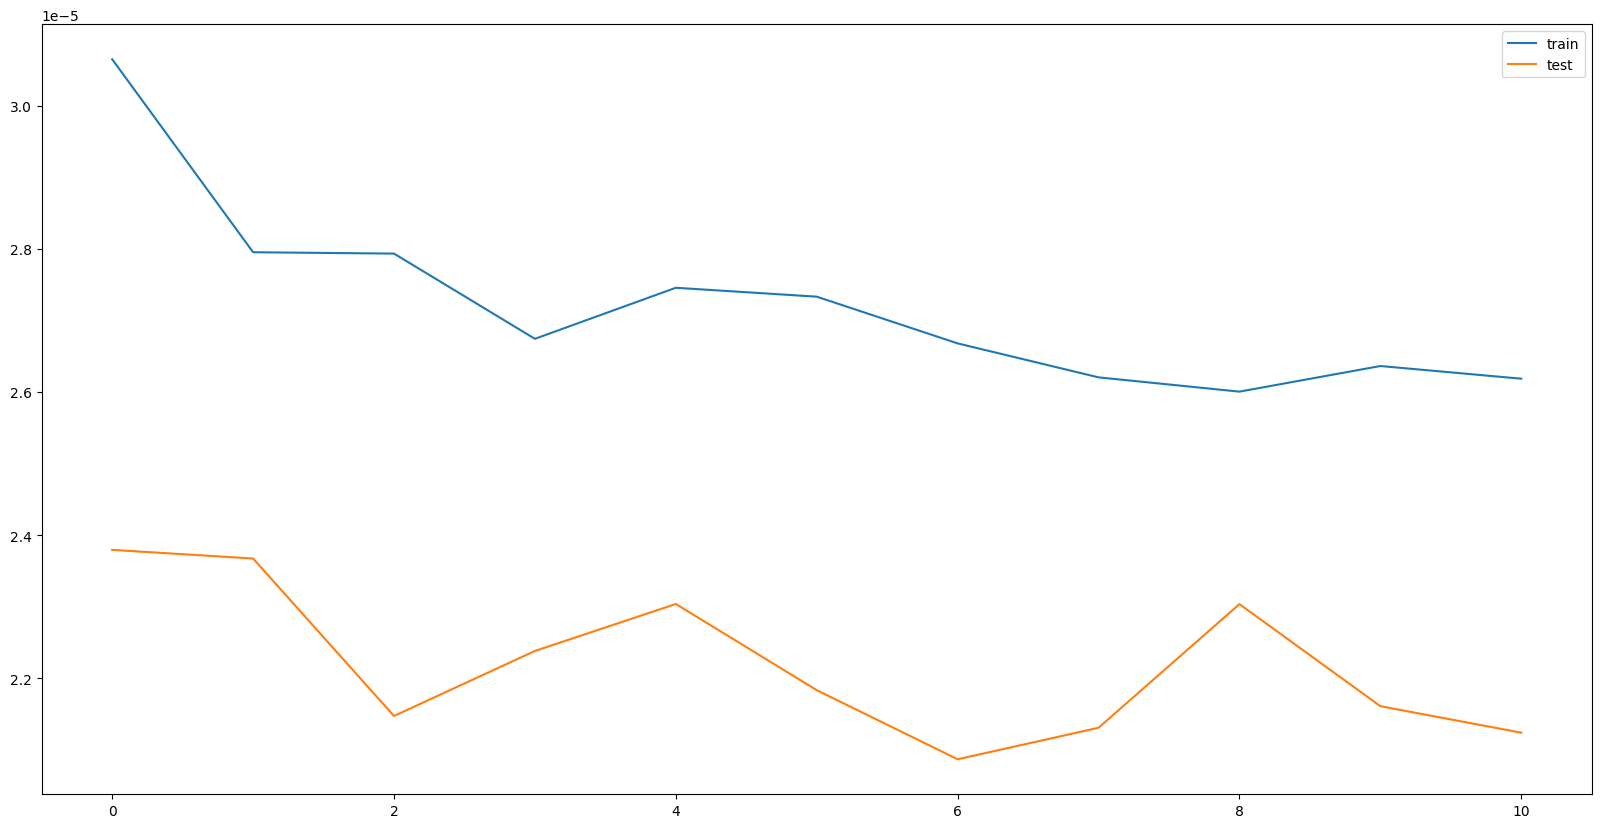

In [5]:
ia_plot_history(history)

In [ ]:
save_model(model,'mi_modelo.h5')
joblib.dump(scaler_x, 'scaler_X.pkl')  # Saves the scaler
joblib.dump(scaler_y, 'scaler_Y.pkl')  # Saves the scaler
joblib.dump(encoder, 'encoder_filename.pkl')  # Saves the encoder